In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/data.csv')

### 모든 department의 물품에서 재구매율 높은 물건 확인

In [5]:
df[df['department'] == 'produce'].groupby('product_name')['reordered'].mean() * 100

product_name
100% Baby Kale                                                          51.363237
100% Florida Super Red Grapefruit Juice                                 34.513274
100% Natural Broccoli Sprouts With Long Lasting Antioxidant Activity    44.642857
3 Color Deli Coleslaw                                                   49.403641
3 Jumbo Romaine Hearts                                                  51.888218
                                                                          ...    
Yukon Gold Potatoes 5lb Bag                                             48.299231
Yukon Gold Potatoes Bag                                                 32.580645
Zucchini Noodles                                                        48.867925
Zucchini Squash                                                         51.878965
Zucchini Squash, Baby Courgette                                         36.448598
Name: reordered, Length: 1684, dtype: float64

In [19]:
num_cols = len(df['department'].unique())

In [91]:
num_rows = num_cols

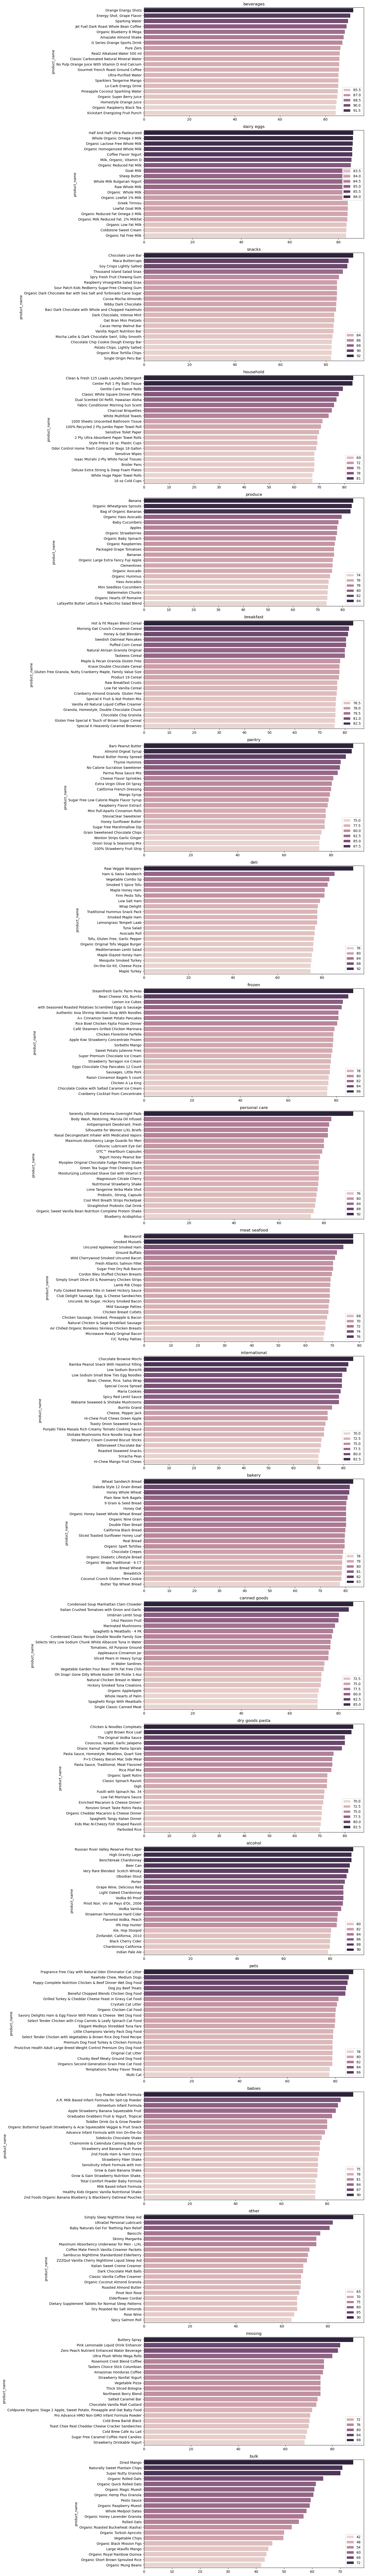

In [97]:
fig, axes = plt.subplots(num_rows, 1, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(df['department'].unique()):
    product_reordered_rate = df[df['department'] == col].groupby('product_name')['reordered'].mean() * 100
    top_products = product_reordered_rate.sort_values(ascending=False).head(20)
    sns.barplot(x=top_products.values, y=top_products.index, hue=top_products.values, ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# plt.xlabel('Product name')
# plt.ylabel('Reordered rate')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 구매율이 높은 department top3 확인 결과 produce는 역시 바나나가 제일 많았습니다.
- dairy eggs는 확실히 우유의 재구매 수가 많았습니다.
- beverage는 음료수인데 에너지 음료의 재구매율이 제일 높았습니다.
- 30일 이후 주기의 재구매율이 높은 personal care에서는 생리대 재구매율이 가장 높았습니다.
- 확실한 것은 유통기한이 짧은 물품들의 재구매율이 매우 높으며 유통기한이나 오래사용할 수 있는 물품은 재구매 주기가 긴 것 같습니다.

### 카트에 추가한 순서에 따른 재구매율 확인하기
- 기준으로 최소 100번 이상 구매했을 경우

In [7]:
cart_order_reordered=df.groupby('add_to_cart_order')['reordered'].sum()

In [9]:
cart_order_reordered[cart_order_reordered.values >= 100]

add_to_cart_order
1     2178183
2     2068060
3     1889311
4     1696923
5     1507665
       ...   
67        162
68        145
69        128
70        127
71        110
Name: reordered, Length: 71, dtype: int64

In [11]:
cart_order_reordered_rate = df.groupby('add_to_cart_order')['reordered'].mean()*100

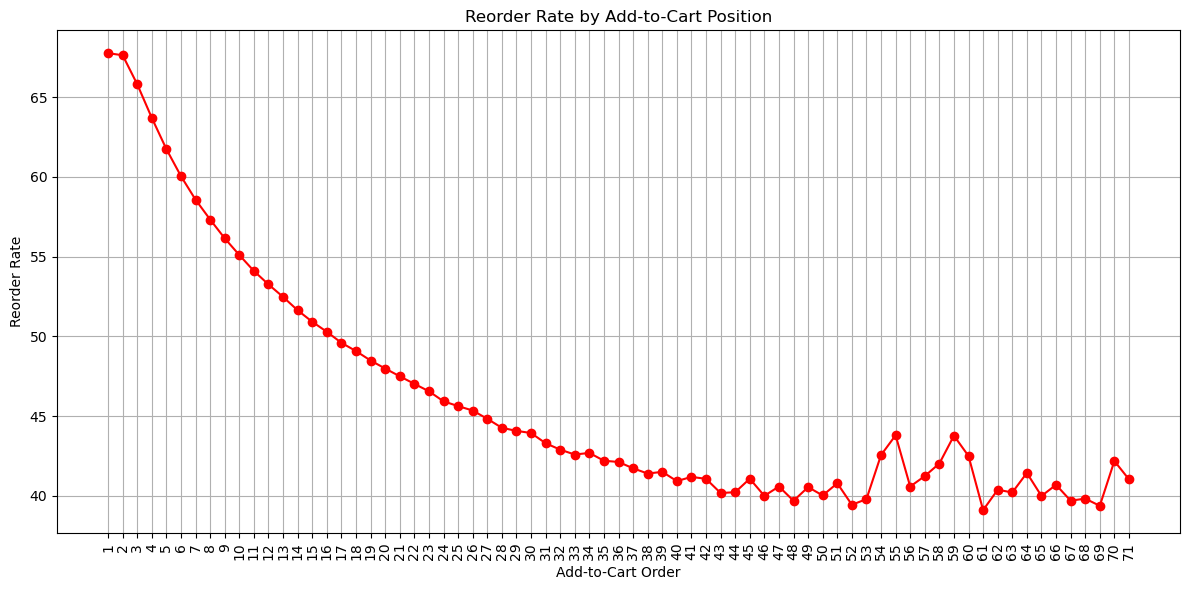

In [35]:
cart_order_reordered_rate = cart_order_reordered_rate[cart_order_reordered_rate.index <= 71]

plt.figure(figsize=(12,6))
plt.plot(cart_order_reordered_rate.index, cart_order_reordered_rate.values, marker='o', linestyle='-', c='r')
plt.xlabel("Add-to-Cart Order")
plt.ylabel("Reorder Rate")
plt.title("Reorder Rate by Add-to-Cart Position")
plt.xticks(range(1, 72), rotation=90)
plt.tight_layout()
plt.grid()

- 장바구니에 넣는 순서가 높아질 수록 재구매율이 줄어드는 것을 확인
- 위의 그래프와 같이 첫번째로 넣는 물품일 수록 재구매율이 높아지는 것으로 보입니다.
- **장바구니에 넣는 순서에 따라서도 재구매율과의 상관성이 있는 것**으로 보입니다.
- 해당 순서를 재구매 예측할 때 넣어주면 좋을 것 같습니다.

### 재구매하는 department마다 구매 시간 확인

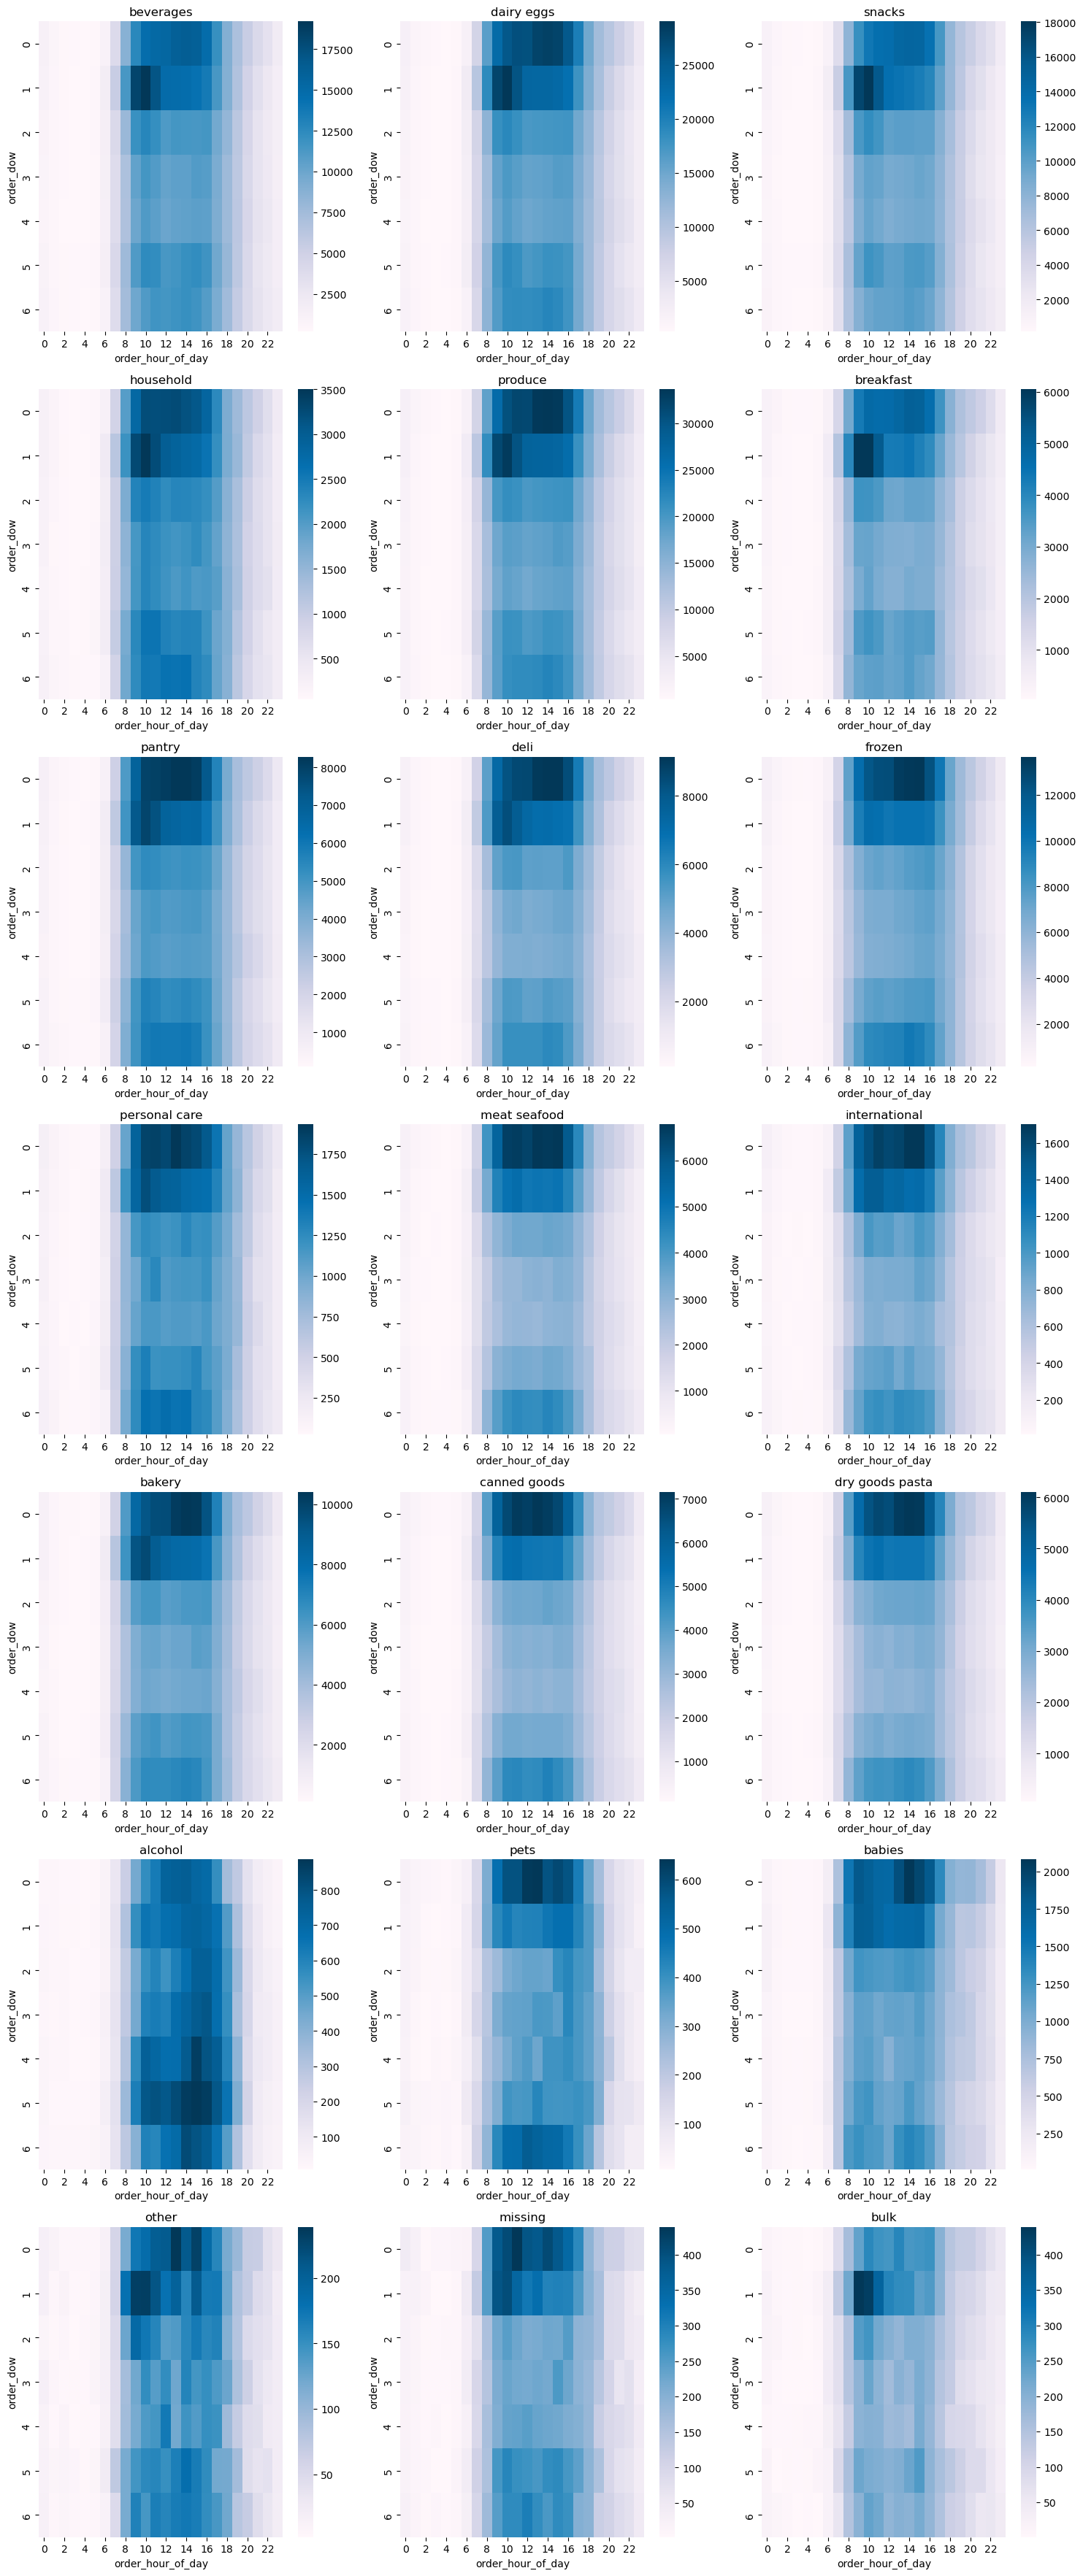

In [113]:
num_cols = len(df['department'].unique())
num_rows = (num_cols // 3) + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(df['department'].unique()):
    a = df[(df['department'] == col) & df['reordered'] == 1].groupby(['order_hour_of_day', 'order_dow'])['order_id'].nunique().unstack(fill_value=0)
    sns.heatmap(a.T, cmap='PuBu', ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- 결과 앞서 봤던 일요일과 월요일에 구매 횟수가 많은 것과 같이 거의 일요일 아니면 월요일에 대부분 구매를 합니다. 
- 하지만 다른 점으로는 alcohol구매는 대부분 금요일에 많이 분 포하는 것으로 확인 됬습니다. 아마 퇴근 후 주말인 영향이 크게 있는 것으로 보입니다.

RFR(Recency, Frequency, Reordered) 분석은 재구매 정보를 추가하여 고객 행동을 평가하는 유용한 방법입니다. RFR 분석을 진행하는 방법은 다음과 같습니다:

### 1. **데이터 준비**
   - 고객 ID, 주문 날짜, 재구매 여부(0 또는 1) 등의 데이터가 포함되어야 합니다.

### 2. **Recency 계산**
   - 각 고객의 마지막 구매일로부터 현재 날짜까지의 일수를 계산합니다.

### 3. **Frequency 계산**
   - 특정 기간 동안 고객이 구매한 총 횟수를 세어 빈도를 계산합니다.

### 4. **Reordered 계산**
   - 재구매 여부의 평균을 계산하여 고객이 얼마나 자주 재구매하는지를 나타내는 비율을 구합니다.

### 5. **RFR 점수화**
   - Recency, Frequency, Reordered를 점수화합니다. 각 요소에 대해 높은 점수를 매겨 고객을 세분화할 수 있습니다.

### 6. **고객 세분화**
   - RFR 점수를 바탕으로 고객을 여러 그룹으로 나누고, 맞춤형 마케팅 전략을 수립합니다.